In [25]:
#'''
import numpy as np
import pandas as pd
import urllib.request
from sklearn.mixture import GaussianMixture
import math
import random
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
#'''
from collections import Counter


In [138]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

In [184]:
num_bins = 20
paper_alpha_list = []  #Proportion of left curve for each paper
paper_tf_list = []     # dict(word->tf) for each paper
paper_idf_dict = {}    # dict(word->idf) for reference paper
paper_word_list = []   # df(word, alpha, cohession_score) for each paper
paper_alpha_word_list = []  # [dict(word->alpha)] for each paper
show_distributions = False
ignore_zero = False

def reset_var(n_bins=20, ig_zero = False, show_d = False):
    global num_bins
    num_bins = n_bins
    global paper_alpha_list  #Proportion of left curve for each paper
    paper_alpha_list = []
    global paper_tf_list     # dict(word->tf) for each paper
    paper_tf_list = []
    global paper_idf_dict    # dict(word->idf) for reference paper
    paper_idf_dict = {}
    global paper_word_list   # df(word, alpha, cohession_score) for each paper
    paper_word_list = []
    global paper_alpha_word_list
    paper_alpha_word_list = []
    global ignore_zero
    ignore_zero = ig_zero
    global show_distributions
    show_distributions = show_d

## Get $\alpha$ for each term

In [2]:
def _isNum(str):
    if(any(dig.isdigit() for dig in str) == True):
        return True
    else:
        return False

def _parse(s):
    tuples = s.split('), ')
    out = []
    for x in tuples:
        #print(x)
        if(len(x.strip('[]()""\n').split(', ')) != 4):
            print("error string: ", s)
            raise Exception ("Error String")
        a,b,c,d = x.strip('[]()""\n').split(', ')
        a = a.replace("'", "")
        d = d.replace("'", "")
        #print(a, b, c, d)
        if(_isNum(b) == True):
            b = float(b)
        else:
            b = b.replace("'", "")
        out.append([str(a), str(b), float(c), str(d)])
    return out

In [22]:

def getListofWords(pin):
    urlstr = "http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs="
    pmidurl = urlstr + str(pin)
    pmidurl = pmidurl.replace("]", "").replace("[", "")
    print(pmidurl)
    with urllib.request.urlopen(pmidurl) as url:
        string_data = url.read().decode("utf-8")
        list_words = _parse(string_data)
        
        try:
            #global word_list
            
            worddf = pd.DataFrame(list_words, columns=['Word', 'CohessionScore', 'Freq', 'Association'])
            # convert stopwords into cohession score = -1
            #print("step 1")
            worddf.loc[worddf['CohessionScore'] == 'stopword', 'CohessionScore'] = 0
            worddf.loc[worddf['CohessionScore'] == None, 'CohessionScore'] = 0
            worddf.loc[worddf['CohessionScore'] == "None", 'CohessionScore'] = 0
            #print("step 2")
            # remove any remaining spaces
            worddf.Association = worddf.Association.str.strip()
            #print("step 3")
            worddf.Word = worddf.Word.str.strip()
            #print("step 4")
            # convert CohessionScore from object to numeric
            worddf.CohessionScore = pd.to_numeric(worddf.CohessionScore)
            #print("step 5")
            worddf = worddf.drop(['Freq', 'Association'], axis=1)
            
            worddf = plotHistogram(worddf)
            
            return worddf
            
        except Exception as e:
            print("getListofWords error", e)
            raise e
            return 0

In [194]:
def plotHistogram(word_frame):
    if(ignore_zero == True):
        y = word_frame[word_frame.CohessionScore > 0]["CohessionScore"].values
        yind = word_frame.index[word_frame.CohessionScore > 0].tolist()
    else:
        y = word_frame.CohessionScore.values
        yind = word_frame.index.tolist()
        
    word_frame['alpha'] = pd.Series(np.ones(word_frame.shape[0]), index=word_frame.index)
    
    size = 1000
    x = np.linspace(0, 1, 10000)

    # Initialize the gmm model
    gmm = GaussianMixture(n_components=2, covariance_type="full", tol=0.001)
    gmm = gmm.fit(X=np.expand_dims(y, 1))

    #Get values of means and sigmas
    mu0 = gmm.means_[0]
    mu1 = gmm.means_[1]
    sigma0 = math.sqrt(gmm.covariances_[0])
    sigma1 = math.sqrt(gmm.covariances_[1])

    #plot the fitter curves along with the distribution 
    if(show_distributions==True):
        plt.hist(y, bins=num_bins)
        plt.plot(x,mlab.normpdf(x, mu0, sigma0))
        plt.plot(x,mlab.normpdf(x, mu1, sigma1))
        #plt.axvline(gmm.means_[0])
        #plt.axvline(gmm.means_[1])
        print("Means: ", gmm.means_[0], " ", gmm.means_[1])
        print("Covariances: ", gmm.covariances_[0], " ", gmm.covariances_[1])
        plt.show()
        print("----------------------------------------------------------------------------------")
    
    # Get Probability score
    probability_score = np.array(gmm.predict_proba(X=np.expand_dims(y, 1)))
    if mu0 < mu1:
        l = 0
    else:
        l = 1
    word_frame.loc[yind, 'alpha'] = probability_score[:,l]
    #print(probability_score)
    left_score = np.mean(probability_score[:, l])
    print("Left Normal Curve score or alpha for this paper = ", left_score)
    paper_alpha_list.append(left_score)
    return word_frame

### Modified TF

$$TF = \frac{(k+1)*(tf)^p}{k(1 + b(1 - \alpha)^b) + (tf)^p}$$

In [79]:
def ComputeTF(tf, a, b = 4, p = 0.5, k = 5):
    t = np.power(tf, p)
    d = np.power((1-a), b)
    d = 1 + b*d
    num = (k+1)*t
    den = k*d + t
    return num/den

In [81]:
def ComputeScore(TF, IDF, a_paper):
    return TF*IDF*a_paper

### Prepare PMID


In [157]:
def PreparePMID(s):
    s=s.split(" ")
    ss=[]
    i=3
    while(i<len(s)):
        ss.append(s[i])
        i=i+5
    return ss

## Doing preprocessing

Create TF dict, IDF dict, word list

http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=18500472
Means:  [ 0.18888267]   [ 0.06897138]
Covariances:  [[ 0.00680176]]   [[ 0.00025808]]


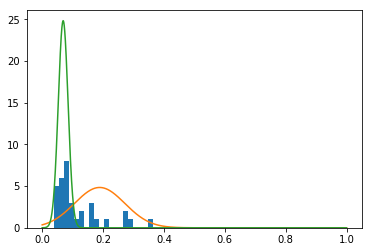

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.39592740584
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=10220102
Means:  [ 0.07965178]   [ 0.17765172]
Covariances:  [[ 0.00083617]]   [[ 0.00492685]]


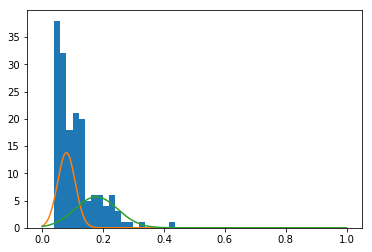

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.691864369439
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=26639710
Means:  [ 0.07007375]   [ 0.17912954]
Covariances:  [[ 0.00018523]]   [[ 0.00619886]]


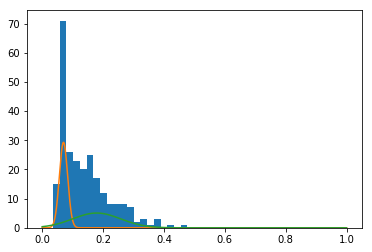

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.378545855254
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=20518192
Means:  [ 0.07186727]   [ 0.19785342]
Covariances:  [[ 0.00025447]]   [[ 0.00782172]]


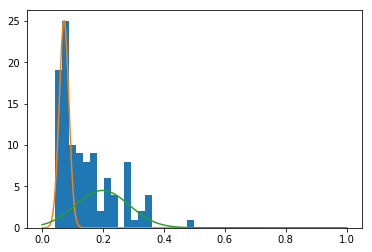

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.44319681123
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=24391071
Means:  [ 0.06989349]   [ 0.15894675]
Covariances:  [[ 0.00024461]]   [[ 0.00493374]]


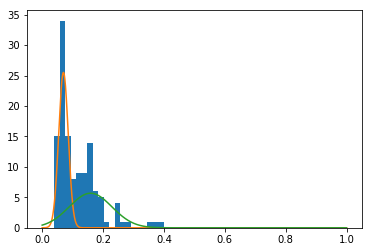

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.479320098513
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=20169875
Means:  [ 0.29473188]   [ 0.10076118]
Covariances:  [[ 0.01665075]]   [[ 0.00202529]]


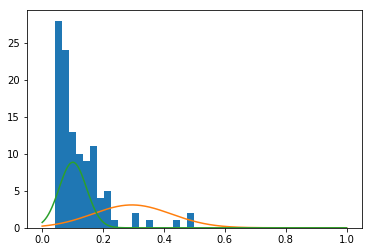

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.106034549818
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=21410890
Means:  [ 0.08110378]   [ 0.19803353]
Covariances:  [[ 0.00060901]]   [[ 0.00556779]]


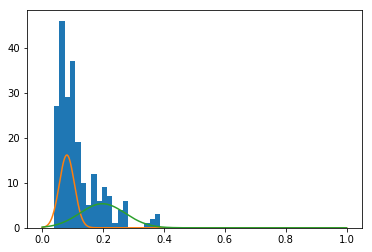

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.680833703689
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=1378782
Means:  [ 0.07188842]   [ 0.17037202]
Covariances:  [[ 0.00025509]]   [[ 0.00658377]]


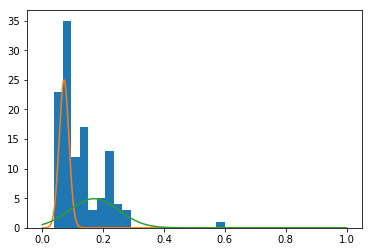

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.478404130579
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=8264911
Means:  [ 0.06212892]   [ 0.15584337]
Covariances:  [[ 0.00012235]]   [[ 0.00393974]]


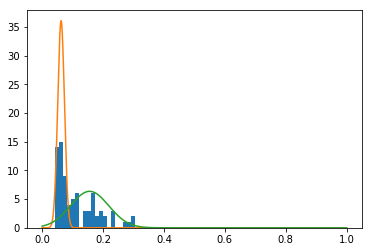

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.454180575291
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=21638803
Means:  [ 0.17400086]   [ 0.07556747]
Covariances:  [[ 0.00514304]]   [[ 0.00041166]]


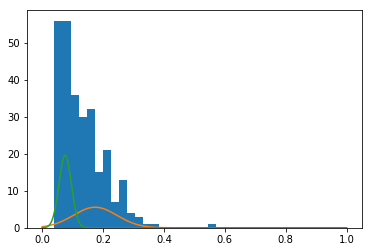

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.569538545815
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=25125235
Means:  [ 0.07260274]   [ 0.17414006]
Covariances:  [[ 0.00035159]]   [[ 0.00608677]]


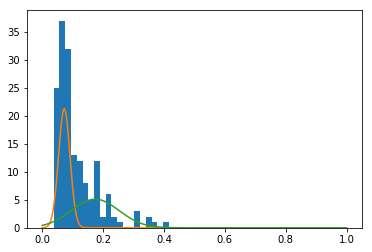

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.606321486438
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=11766630
Means:  [ 0.079999]   [ 0.19716603]
Covariances:  [[ 0.00062303]]   [[ 0.00837885]]


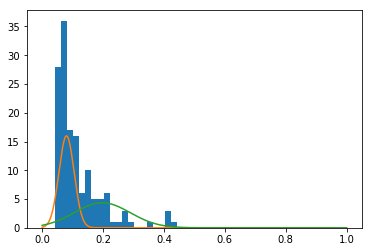

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.678673598877
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=25759588
Means:  [ 0.18412013]   [ 0.08137527]
Covariances:  [[ 0.00364838]]   [[ 0.00066866]]


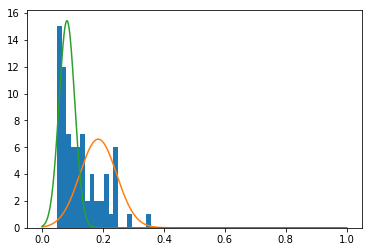

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.419706482781
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=26120539
Means:  [ 0.09421131]   [ 0.23775224]
Covariances:  [[ 0.00124099]]   [[ 0.01288374]]


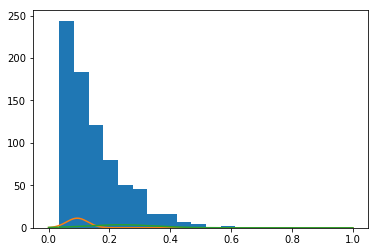

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.597714855092
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=6561044
Means:  [ 0.27610208]   [ 0.10256558]
Covariances:  [[ 0.01912562]]   [[ 0.0011687]]


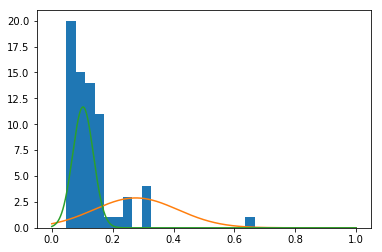

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.167302342232
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=10085198
Means:  [ 0.17288366]   [ 0.07245832]
Covariances:  [[ 0.006063]]   [[ 0.00024974]]


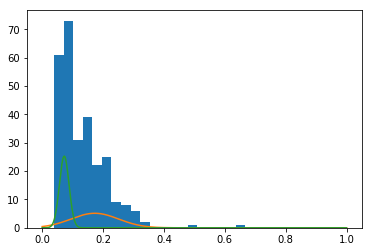

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.57838924071
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=20703189
Means:  [ 0.09057094]   [ 0.24278228]
Covariances:  [[ 0.00126566]]   [[ 0.00317868]]


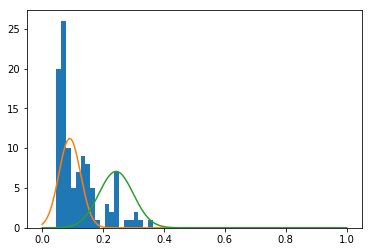

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.799059439147
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=21249137
Means:  [ 0.08966941]   [ 0.22763582]
Covariances:  [[ 0.00108343]]   [[ 0.0096384]]


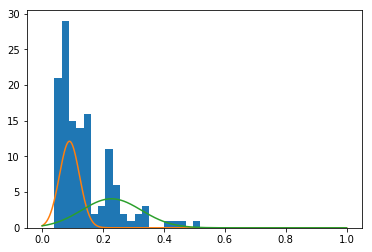

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.634019364538
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=22151782
Means:  [ 0.06705584]   [ 0.17643968]
Covariances:  [[ 0.00015816]]   [[ 0.00508544]]


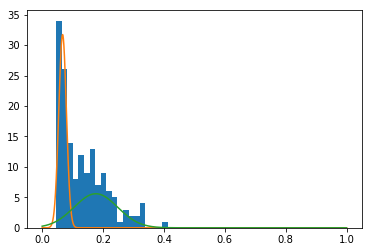

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.411562852638
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=11577787
Means:  [ 0.06801667]   [ 0.17518108]
Covariances:  [[ 0.00018849]]   [[ 0.00444853]]


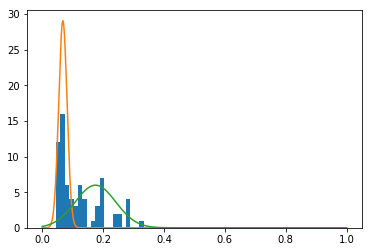

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.482868064741
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=21410892
Means:  [ 0.09961904]   [ 0.24611804]
Covariances:  [[ 0.00175349]]   [[ 0.00663746]]


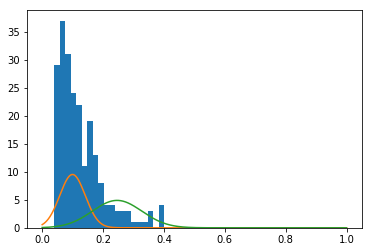

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.822794532199
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=12826765
Means:  [ 0.08533662]   [ 0.17766424]
Covariances:  [[ 0.00100522]]   [[ 0.00290021]]


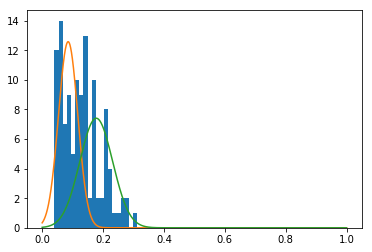

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.5350856542
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=11680910
Means:  [ 0.07559135]   [ 0.19840924]
Covariances:  [[ 0.00067143]]   [[ 0.00207486]]


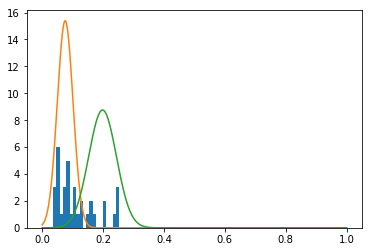

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.688074541535
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=26690977
Means:  [ 0.24767146]   [ 0.11292277]
Covariances:  [[ 0.01253065]]   [[ 0.00224997]]


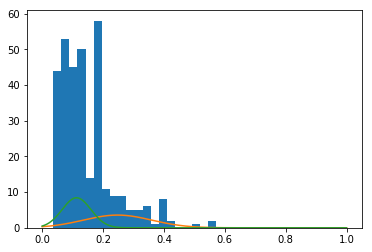

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.265012322235
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=15258734
Means:  [ 0.0940011]   [ 0.2225271]
Covariances:  [[ 0.00158259]]   [[ 0.00828488]]


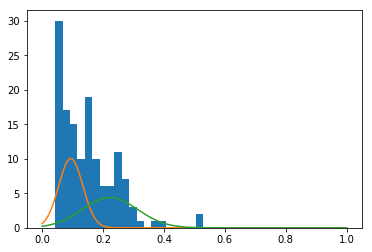

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.577315333532
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=10312155
Means:  [ 0.09591375]   [ 0.23725032]
Covariances:  [[ 0.00169066]]   [[ 0.01337879]]


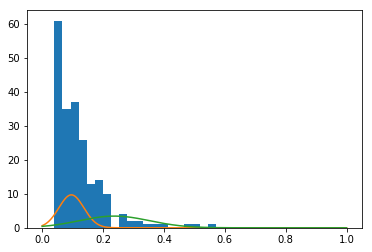

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.826681167374
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=21979238
Means:  [ 0.0956048]   [ 0.2920831]
Covariances:  [[ 0.00210199]]   [[ 0.01640875]]


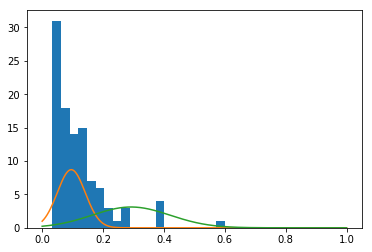

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.864481534842
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=20078852
Means:  [ 0.06985697]   [ 0.16384645]
Covariances:  [[ 0.00029963]]   [[ 0.00399896]]


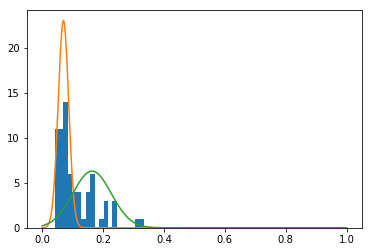

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.57446309203
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=9890101
Means:  [ 0.06495248]   [ 0.17066984]
Covariances:  [[ 0.00019034]]   [[ 0.00375011]]


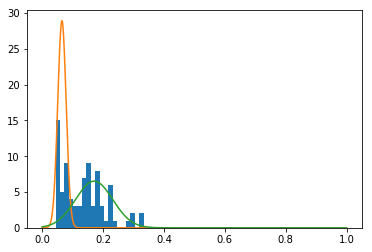

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.32888361434
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=11727406
Means:  [ 0.08388588]   [ 0.23153101]
Covariances:  [[ 0.00064065]]   [[ 0.0088483]]


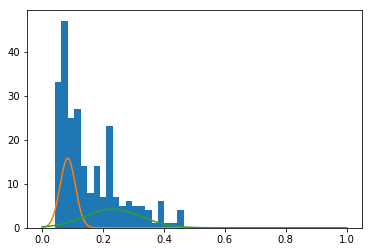

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.510725867253
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=27686758
Means:  [ 0.07340031]   [ 0.18680362]
Covariances:  [[ 0.00048171]]   [[ 0.00665049]]


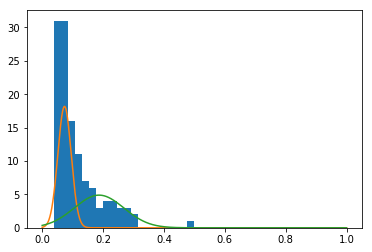

----------------------------------------------------------------------------------
Left Normal Curve score or alpha for this paper =  0.640238776109


In [98]:
pmid_list = [18500472
,10220102
,26639710
,20518192
,24391071
,20169875
, 21410890 
, 1378782
, 8264911
, 21638803
, 25125235
, 11766630
, 25759588
, 26120539
, 6561044
, 10085198
, 20703189
, 21249137
, 22151782
, 11577787
, 21410892
, 12826765
, 11680910
, 26690977
, 15258734
, 10312155
, 21979238
, 20078852
, 9890101
, 11727406
, 27686758
]
reset_var(n_bins=20, ig_zero=True)
for pm in pmid_list:
    df = getListofWords(pm)
    paper_word_list.append(df)
    paper_tf_list.append(dict(Counter(df.Word)))
    temp_dict = {}
    for _, d in df.iterrows():
        temp_dict[d["Word"]] = d["alpha"]
    paper_alpha_word_list.append(temp_dict)

In [99]:
N = len(pmid_list)
for w in paper_tf_list[0]:
    count = 0
    for paper in paper_tf_list:
        if(w in paper):
            count=count+1
    paper_idf_dict[w] = np.log((N / (count)) + 0.01)

In [113]:
style_score_list = []
Threshold = 0.9
coef = 0.01 

ref_words = paper_tf_list[0]
for ind, paper in enumerate(paper_tf_list):
    style_score = 0
    for word in ref_words:
        if word not in paper:
            if paper_alpha_word_list[0][word] > Threshold:
                TFscore = ComputeTF(tf=ref_words[word], a=paper_alpha_word_list[0][word])
                IDF_score = paper_idf_dict[word]
                al = paper_alpha_list[0]
                style_score = style_score + coef*ComputeScore(TF=TFscore, IDF=IDF_score, a_paper=al)
        else:
            TFscore = ComputeTF(tf=paper[word], a=paper_alpha_word_list[ind][word])
            IDF_score = paper_idf_dict[word]
            al = paper_alpha_list[ind]
            style_score = style_score + ComputeScore(TF=TFscore, IDF=IDF_score, a_paper=al)
    style_score_list.append(style_score)

In [115]:
style_score_list = np.array(style_score_list)
style_score_list = style_score_list/style_score_list[0]

In [130]:
style_score_list

array([ 1.        ,  0.50990886,  0.27924189,  0.1530637 ,  0.21797708,
        0.02487261,  0.3913742 ,  0.23972339,  0.13451767,  0.28622099,
        0.52355256,  0.44553452,  0.18555505,  0.84349931,  0.02124593,
        0.32710585,  0.40861501,  0.40491544,  0.10537775,  0.20959209,
        0.34546983,  0.19252873,  0.28548864,  0.08855024,  0.28668884,
        0.38646565,  0.53411297,  0.16835464,  0.04579868,  0.2563602 ,
        0.27062057])

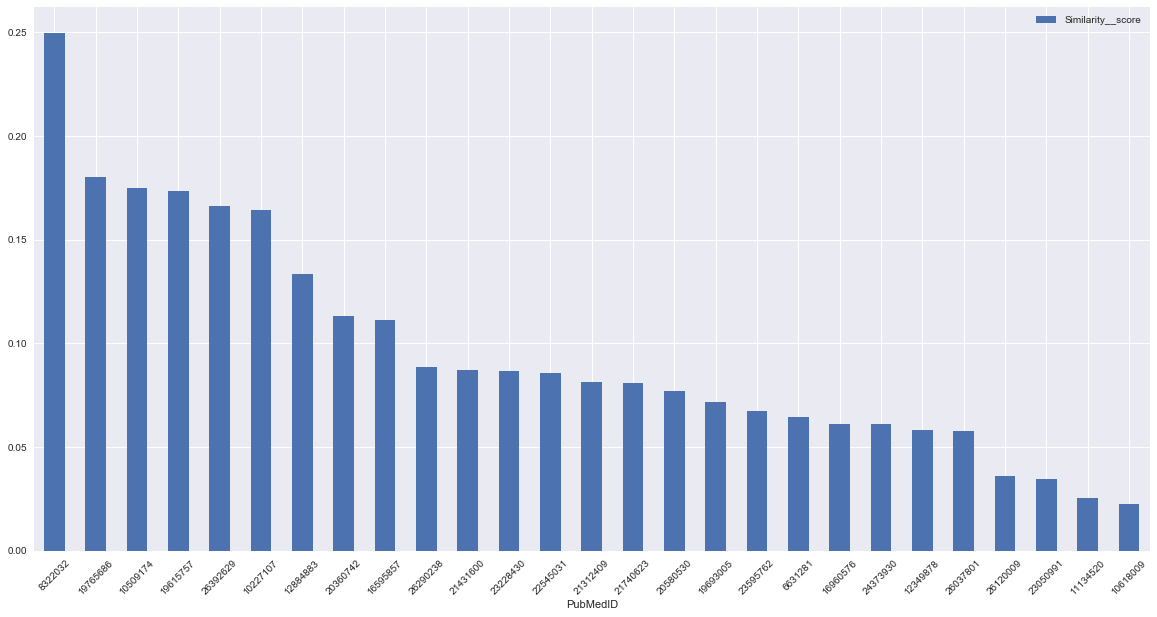

    PubMedID  Similarity__score
0   10719138           1.000000
7    8322032           0.249641
15  19765686           0.180362
5   10509174           0.174917
12  19615757           0.173186
2   26392629           0.166088
21  10227107           0.164179
1   12884883           0.133546
4   20360742           0.113149
26  16595857           0.111342
18  26290238           0.088313
8   21431600           0.087282
13  23228430           0.086435
17  22545031           0.085886
14  21312409           0.081073
27  21740623           0.080872
3   20580530           0.077077
16  19693005           0.071640
11  23595762           0.067391
23   6631281           0.064403
20  16960576           0.061223
19  24373930           0.060868
10  12349878           0.058356
6   26037801           0.057536
22  26120009           0.036177
9   23050991           0.034580
25  11134520           0.025504
24  10618009           0.022458


In [202]:
xx = [str(x) for x in pmid_list]
comparison_df = pd.DataFrame({"PubMedID": xx, "Similarity__score": style_score_list})
comparison_df.sort_values(['Similarity__score'], ascending=[0])[1:].plot.bar(x="PubMedID")
#sns.barplot(comparison_df.PubMedID, list(comparison_df.Similarity__score*100))
plt.xticks(rotation=45)
plt.show()
comparison_df = comparison_df.sort_values(['Similarity__score'], ascending=[0])
print(comparison_df)

length of pmid=  28
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=10719138
Left Normal Curve score or alpha for this paper =  0.763549281232
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=12884883
Left Normal Curve score or alpha for this paper =  0.49474025922
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=26392629
Left Normal Curve score or alpha for this paper =  0.715579925632
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=20580530
Left Normal Curve score or alpha for this paper =  0.39855332408
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=20360742
Left Normal Curve score or alpha for this paper =  0.39316784976
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=10509174
Left Normal Curve score or alpha for this paper =  0.781085551565
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=26037801
Left Normal Curve score or alpha for this paper =  0.562424251519
http://abel.lis.illinois.edu/cgi-bin/c

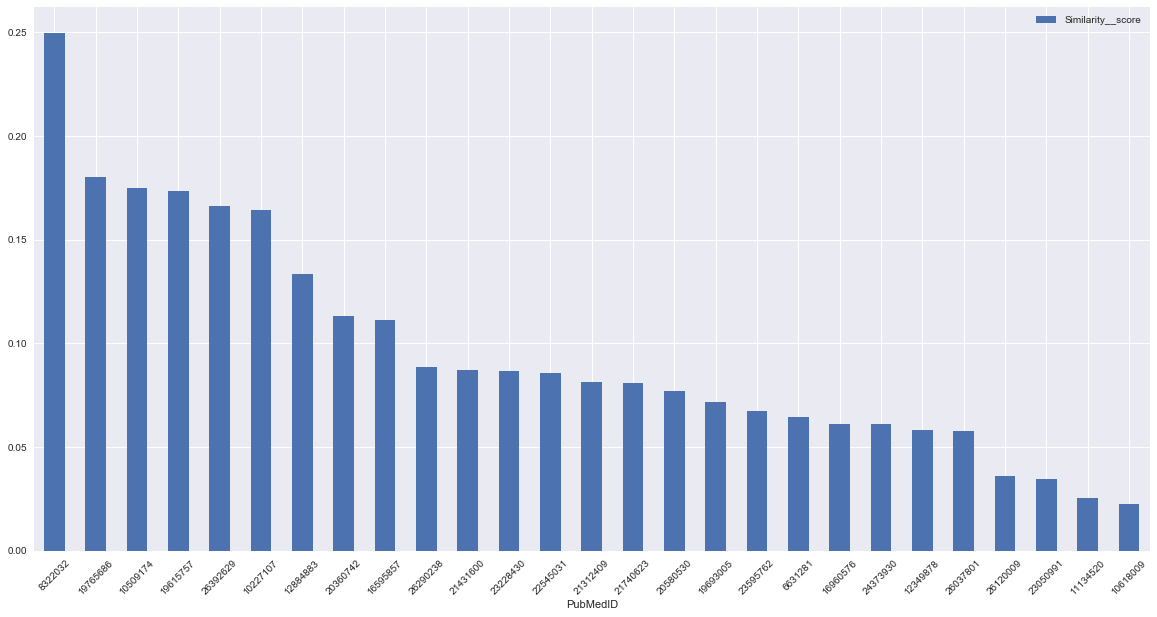

    PubMedID  Similarity__score
0   10719138           1.000000
7    8322032           0.249641
15  19765686           0.180362
5   10509174           0.174917
12  19615757           0.173186
2   26392629           0.166088
21  10227107           0.164179
1   12884883           0.133546
4   20360742           0.113149
26  16595857           0.111342
18  26290238           0.088313
8   21431600           0.087282
13  23228430           0.086435
17  22545031           0.085886
14  21312409           0.081073
27  21740623           0.080872
3   20580530           0.077077
16  19693005           0.071640
11  23595762           0.067391
23   6631281           0.064403
20  16960576           0.061223
19  24373930           0.060868
10  12349878           0.058356
6   26037801           0.057536
22  26120009           0.036177
9   23050991           0.034580
25  11134520           0.025504
24  10618009           0.022458


In [201]:
s = "0 10719138 vs 10719138 91 \
1 10719138 vs 12884883 34 \
2 10719138 vs 26392629 34 \
3 10719138 vs 20580530 30 \
4 10719138 vs 20360742 30 \
5 10719138 vs 10509174 29 \
6 10719138 vs 26037801 28 \
7 10719138 vs 8322032 28 \
8 10719138 vs 21431600 28 \
9 10719138 vs 23050991 27 \
10 10719138 vs 12349878 27 \
11 10719138 vs 23595762 26 \
12 10719138 vs 19615757 26 \
13 10719138 vs 23228430 26 \
14 10719138 vs 21312409 26 \
15 10719138 vs 19765686 26 \
16 10719138 vs 19693005 26 \
17 10719138 vs 22545031 25 \
18 10719138 vs 26290238 25 \
19 10719138 vs 24373930 25 \
20 10719138 vs 16960576 25 \
21 10719138 vs 10227107 25 \
22 10719138 vs 26120009 25 \
23 10719138 vs 6631281 25 \
24 10719138 vs 10618009 25 \
25 10719138 vs 11134520 25 \
26 10719138 vs 16595857 25 \
27 10719138 vs 21740623 25"
pmid_list = PreparePMID(s)
print("length of pmid= ", len(pmid_list))

#Preprocessing - Calculating TFs, IDF, Alpha
reset_var(n_bins=20, ig_zero=True, show_d=False)
for pm in pmid_list:
    df = getListofWords(pm)
    paper_word_list.append(df)
    paper_tf_list.append(dict(Counter(df.Word)))
    temp_dict = {}
    for _, d in df.iterrows():
        temp_dict[d["Word"]] = d["alpha"]
    paper_alpha_word_list.append(temp_dict)


N = len(pmid_list)
for w in paper_tf_list[0]:
    count = 0
    for paper in paper_tf_list:
        if(w in paper):
            count=count+1
    paper_idf_dict[w] = np.log((N / (count)) + 0.01)
    

#Algorithm 

style_score_list = []
Threshold = 0.85
coef = 0.01 

ref_words = paper_tf_list[0]
for ind, paper in enumerate(paper_tf_list):
    style_score = 0
    for word in ref_words:
        if word not in paper:
            if paper_alpha_word_list[0][word] > Threshold:
                TFscore = ComputeTF(tf=ref_words[word], a=paper_alpha_word_list[0][word])
                IDF_score = paper_idf_dict[word]
                al = paper_alpha_list[0]
                style_score = style_score + coef*ComputeScore(TF=TFscore, IDF=IDF_score, a_paper=al)
        else:
            TFscore = ComputeTF(tf=paper[word], a=paper_alpha_word_list[ind][word])
            IDF_score = paper_idf_dict[word]
            al = paper_alpha_list[ind]
            style_score = style_score + ComputeScore(TF=TFscore, IDF=IDF_score, a_paper=al)
    style_score_list.append(style_score)

style_score_list = np.array(style_score_list)
style_score_list = style_score_list/style_score_list[0]

#Plot similarity score
xx = [str(x) for x in pmid_list]
comparison_df = pd.DataFrame({"PubMedID": xx, "Similarity__score": style_score_list})
comparison_df.sort_values(['Similarity__score'], ascending=[0])[1:].plot.bar(x="PubMedID")
plt.xticks(rotation=45)
plt.show()
comparison_df = comparison_df.sort_values(['Similarity__score'], ascending=[0])
print(comparison_df)

length of pmid=  32
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=11738834
Left Normal Curve score or alpha for this paper =  0.455956564224
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=12888777
Left Normal Curve score or alpha for this paper =  0.797731282558
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=9796780
Left Normal Curve score or alpha for this paper =  0.580290625647
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=10029236
Left Normal Curve score or alpha for this paper =  0.545625907128
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=10415371
Left Normal Curve score or alpha for this paper =  0.794364576221
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=21048974
Left Normal Curve score or alpha for this paper =  0.411155669596
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=26331133
Left Normal Curve score or alpha for this paper =  0.647829311443
http://abel.lis.illinois.edu/cgi-bin

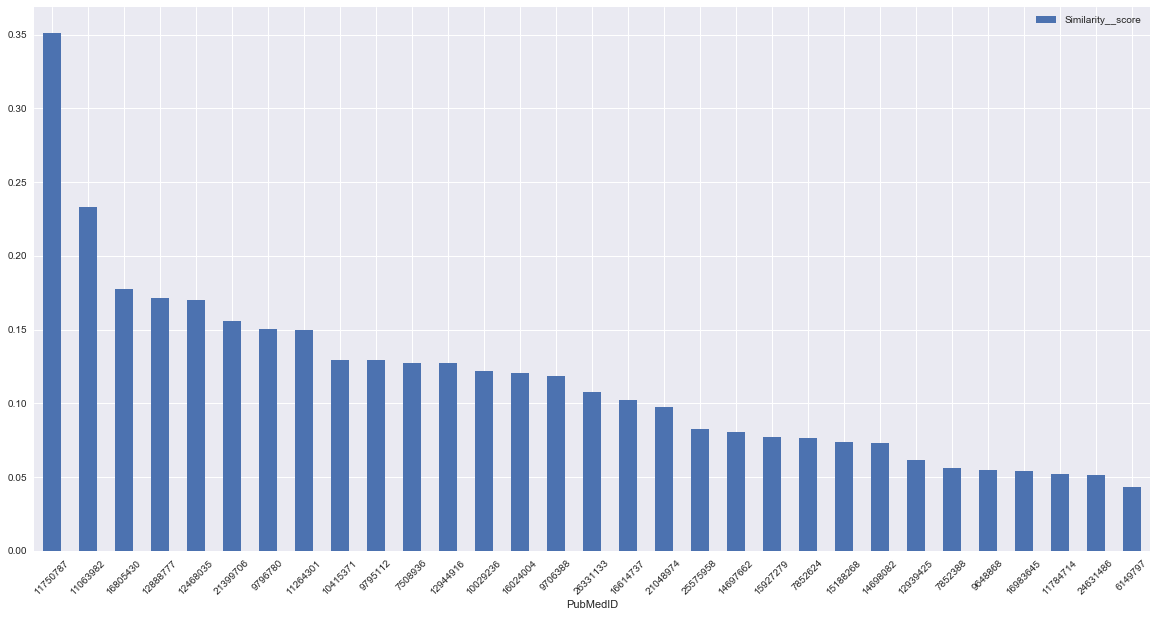

    PubMedID  Similarity__score
0   11738834           1.000000
29  11750787           0.351212
7   11063982           0.232981
17  16805430           0.177387
1   12888777           0.171412
14  12468035           0.170256
10  21399706           0.155914
2    9796780           0.150103
22  11264301           0.149466
4   10415371           0.129044
16   9795112           0.129035
12   7508936           0.127424
9   12944916           0.126955
3   10029236           0.121985
24  16024004           0.120476
27   9706388           0.118206
6   26331133           0.107348
28  16614737           0.101996
5   21048974           0.097213
25  25575958           0.082660
8   14697662           0.080545
18  15927279           0.076972
26   7852624           0.076661
21  15188268           0.073454
30  14698082           0.073230
19  12939425           0.061493
23   7852388           0.056040
11   9648868           0.054633
13  16983645           0.054014
15  11784714           0.051795
20  2463

In [200]:
s = "0 11738834 vs 11738834 134 \
1 11738834 vs 12888777 27 \
2 11738834 vs 9796780 27 \
3 11738834 vs 10029236 26 \
4 11738834 vs 10415371 26 \
5 11738834 vs 21048974 26 \
6 11738834 vs 26331133 26 \
7 11738834 vs 11063982 25 \
8 11738834 vs 14697662 25 \
9 11738834 vs 12944916 25 \
10 11738834 vs 21399706 24 \
11 11738834 vs 9648868 24 \
12 11738834 vs 7508936 24 \
13 11738834 vs 16983645 24 \
14 11738834 vs 12468035 24 \
15 11738834 vs 11784714 23 \
16 11738834 vs 9795112 23 \
17 11738834 vs 16805430 23 \
18 11738834 vs 15927279 23 \
19 11738834 vs 12939425 22 \
20 11738834 vs 24631486 22 \
21 11738834 vs 15188268 22 \
22 11738834 vs 11264301 22 \
23 11738834 vs 7852388 22 \
24 11738834 vs 16024004 22 \
25 11738834 vs 25575958 22 \
26 11738834 vs 7852624 22 \
27 11738834 vs 9706388 22 \
28 11738834 vs 16614737 22 \
29 11738834 vs 11750787 22 \
30 11738834 vs 14698082 22 \
31 11738834 vs 6149797 22 "
pmid_list = PreparePMID(s)
print("length of pmid= ", len(pmid_list))

#Preprocessing - Calculating TFs, IDF, Alpha
reset_var(n_bins=20, ig_zero=True, show_d=False)
for pm in pmid_list:
    df = getListofWords(pm)
    paper_word_list.append(df)
    paper_tf_list.append(dict(Counter(df.Word)))
    temp_dict = {}
    for _, d in df.iterrows():
        temp_dict[d["Word"]] = d["alpha"]
    paper_alpha_word_list.append(temp_dict)


N = len(pmid_list)
for w in paper_tf_list[0]:
    count = 0
    for paper in paper_tf_list:
        if(w in paper):
            count=count+1
    paper_idf_dict[w] = np.log((N / (count)) + 0.01)
    

#Algorithm 

style_score_list = []
Threshold = 0.9
coef = 0.01 

ref_words = paper_tf_list[0]
for ind, paper in enumerate(paper_tf_list):
    style_score = 0
    for word in ref_words:
        if word not in paper:
            if paper_alpha_word_list[0][word] > Threshold:
                TFscore = ComputeTF(tf=ref_words[word], a=paper_alpha_word_list[0][word])
                IDF_score = paper_idf_dict[word]
                al = paper_alpha_list[0]
                style_score = style_score + coef*ComputeScore(TF=TFscore, IDF=IDF_score, a_paper=al)
        else:
            TFscore = ComputeTF(tf=paper[word], a=paper_alpha_word_list[ind][word])
            IDF_score = paper_idf_dict[word]
            al = paper_alpha_list[ind]
            style_score = style_score + ComputeScore(TF=TFscore, IDF=IDF_score, a_paper=al)
    style_score_list.append(style_score)

style_score_list = np.array(style_score_list)
style_score_list = style_score_list/style_score_list[0]

#Plot similarity score
xx = [str(x) for x in pmid_list]
comparison_df = pd.DataFrame({"PubMedID": xx, "Similarity__score": style_score_list})
comparison_df.sort_values(['Similarity__score'], ascending=[0])[1:].plot.bar(x="PubMedID")
#comparison_df.plot.bar(x="PubMedID")
plt.xticks(rotation=45)
plt.show()
comparison_df = comparison_df.sort_values(['Similarity__score'], ascending=[0])
print(comparison_df)

length of pmid=  27
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=12944916
Left Normal Curve score or alpha for this paper =  0.8156727292
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=7706545
Left Normal Curve score or alpha for this paper =  0.489178437472
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=17973327
Left Normal Curve score or alpha for this paper =  0.690312425683
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=21419569
Left Normal Curve score or alpha for this paper =  0.437920851924
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=20186708
Left Normal Curve score or alpha for this paper =  0.716695495844
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=10524342
Left Normal Curve score or alpha for this paper =  0.665081570867
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=18289031
Left Normal Curve score or alpha for this paper =  0.52364133992
http://abel.lis.illinois.edu/cgi-bin/co

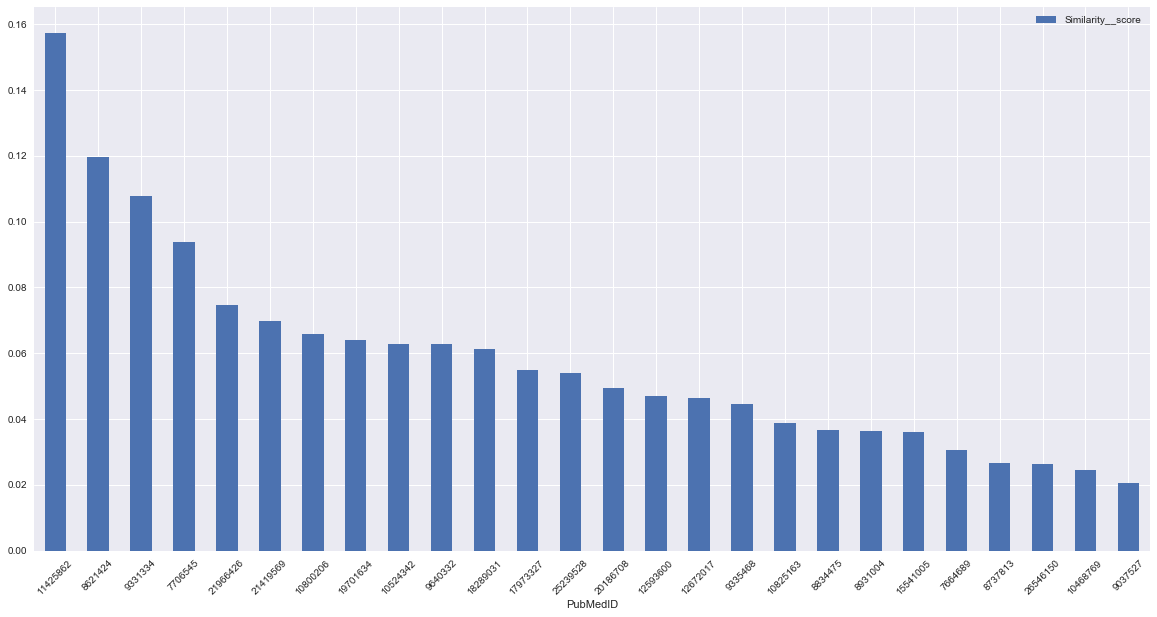

    PubMedID  Similarity__score
0   12944916           1.000000
17  11425862           0.157321
8    8621424           0.119642
7    9331334           0.107869
1    7706545           0.093864
15  21966426           0.074777
3   21419569           0.069701
24  10800206           0.065810
10  19701634           0.064025
5   10524342           0.062775
20   9640332           0.062766
6   18289031           0.061411
2   17973327           0.055011
13  25239528           0.053852
4   20186708           0.049471
14  12593600           0.047099
18  12672017           0.046429
22   9335468           0.044700
9   10825163           0.038670
25   8834475           0.036723
16   8931004           0.036211
21  15541005           0.036086
23   7664689           0.030605
11   8737813           0.026749
12  26546150           0.026311
26  10468769           0.024614
19   9037527           0.020682


In [199]:
s="0 12944916 vs 12944916 137 \
1 12944916 vs 7706545 76 \
2 12944916 vs 17973327 71 \
3 12944916 vs 21419569 69 \
4 12944916 vs 20186708 68 \
5 12944916 vs 10524342 68 \
6 12944916 vs 18289031 63 \
7 12944916 vs 9331334 63 \
8 12944916 vs 8621424 62 \
9 12944916 vs 10825163 62 \
10 12944916 vs 19701634 61 \
11 12944916 vs 8737813 61 \
12 12944916 vs 26546150 60 \
13 12944916 vs 25239528 60 \
14 12944916 vs 12593600 60 \
15 12944916 vs 21966426 60 \
16 12944916 vs 8931004 60 \
17 12944916 vs 11425862 60 \
18 12944916 vs 12672017 60 \
19 12944916 vs 9037527 60 \
20 12944916 vs 9640332 59 \
21 12944916 vs 15541005 59 \
22 12944916 vs 9335468 59 \
23 12944916 vs 7664689 59 \
24 12944916 vs 10800206 59 \
25 12944916 vs 8834475 59 \
26 12944916 vs 10468769 59"
pmid_list = PreparePMID(s)
print("length of pmid= ", len(pmid_list))

#Preprocessing - Calculating TFs, IDF, Alpha
reset_var(n_bins=20, ig_zero=True, show_d=False)
for pm in pmid_list:
    df = getListofWords(pm)
    paper_word_list.append(df)
    paper_tf_list.append(dict(Counter(df.Word)))
    temp_dict = {}
    for _, d in df.iterrows():
        temp_dict[d["Word"]] = d["alpha"]
    paper_alpha_word_list.append(temp_dict)


N = len(pmid_list)
for w in paper_tf_list[0]:
    count = 0
    for paper in paper_tf_list:
        if(w in paper):
            count=count+1
    paper_idf_dict[w] = np.log((N / (count)) + 0.01)
    

#Algorithm 

style_score_list = []
Threshold = 0.9
coef = 0.01 

ref_words = paper_tf_list[0]
for ind, paper in enumerate(paper_tf_list):
    style_score = 0
    for word in ref_words:
        if word not in paper:
            if paper_alpha_word_list[0][word] > Threshold:
                TFscore = ComputeTF(tf=ref_words[word], a=paper_alpha_word_list[0][word])
                IDF_score = paper_idf_dict[word]
                al = paper_alpha_list[0]
                style_score = style_score + coef*ComputeScore(TF=TFscore, IDF=IDF_score, a_paper=al)
        else:
            TFscore = ComputeTF(tf=paper[word], a=paper_alpha_word_list[ind][word])
            IDF_score = paper_idf_dict[word]
            al = paper_alpha_list[ind]
            style_score = style_score + ComputeScore(TF=TFscore, IDF=IDF_score, a_paper=al)
    style_score_list.append(style_score)
print(style_score_list)
style_score_list = np.array(style_score_list)
style_score_list = style_score_list/style_score_list[0]


#Plot similarity score
xx = [str(x) for x in pmid_list]
comparison_df = pd.DataFrame({"PubMedID": xx, "Similarity__score": style_score_list})
comparison_df.sort_values(['Similarity__score'], ascending=[0])[1:].plot.bar(x="PubMedID")
#comparison_df.plot.bar(x="PubMedID")
plt.xticks(rotation=45)
plt.show()
comparison_df = comparison_df.sort_values(['Similarity__score'], ascending=[0])
print(comparison_df)

length of pmid=  26
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=15860370
Left Normal Curve score or alpha for this paper =  0.475333875989
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=24639278
Left Normal Curve score or alpha for this paper =  0.687845041918
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=12509574
Left Normal Curve score or alpha for this paper =  0.73622411869
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=16478287
Left Normal Curve score or alpha for this paper =  0.55753471381
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=23822950
Left Normal Curve score or alpha for this paper =  0.594104364268
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=21434915
Left Normal Curve score or alpha for this paper =  0.447813839419
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=25664657
Left Normal Curve score or alpha for this paper =  0.506810965316
http://abel.lis.illinois.edu/cgi-bin/

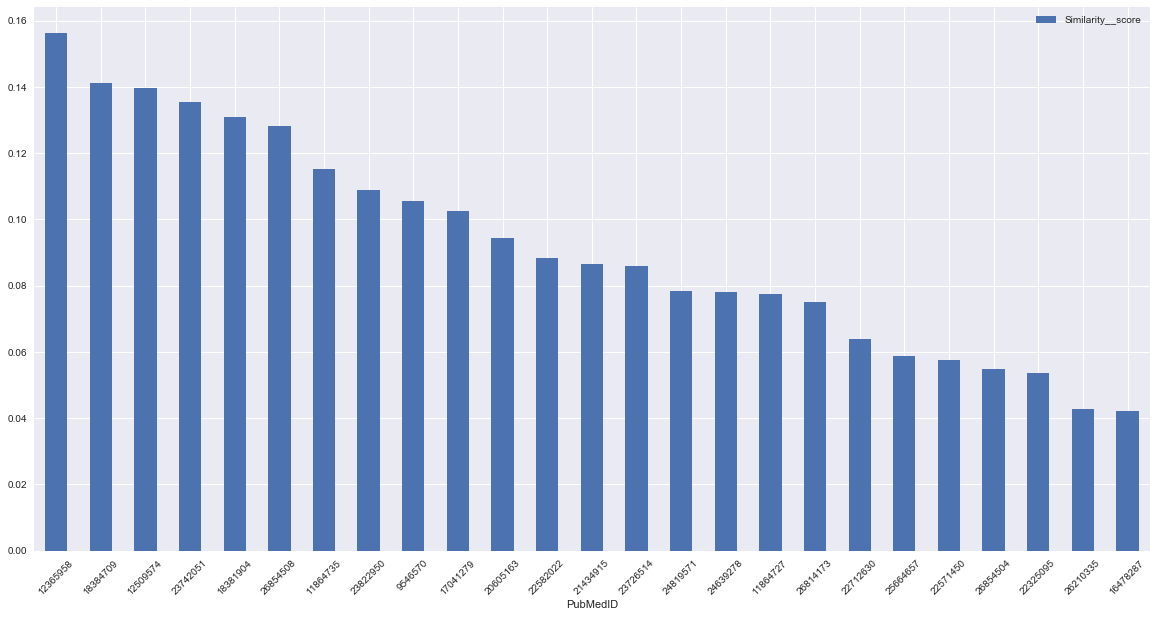

    PubMedID  Similarity__score
0   15860370           1.000000
22  12365958           0.156328
16  18384709           0.141089
2   12509574           0.139839
15  23742051           0.135480
25  18381904           0.130952
13  26854508           0.128234
21  11864735           0.115100
4   23822950           0.109018
8    9546570           0.105475
18  17041279           0.102615
19  20605163           0.094492
12  22582022           0.088485
5   21434915           0.086446
20  23726514           0.086015
23  24819571           0.078275
1   24639278           0.078211
7   11864727           0.077456
14  26814173           0.075034
9   22712630           0.063974
6   25664657           0.058669
10  22571450           0.057427
24  26854504           0.054790
17  22325095           0.053760
11  26210335           0.042750
3   16478287           0.042148


In [198]:
s="0 15860370 vs 15860370 100 \
1 15860370 vs 24639278 47 \
2 15860370 vs 12509574 45 \
3 15860370 vs 16478287 44 \
4 15860370 vs 23822950 43 \
5 15860370 vs 21434915 43 \
6 15860370 vs 25664657 43 \
7 15860370 vs 11864727 42 \
8 15860370 vs 9546570 42 \
9 15860370 vs 22712630 42 \
10 15860370 vs 22571450 41 \
11 15860370 vs 26210335 41 \
12 15860370 vs 22582022 41 \
13 15860370 vs 26854508 40 \
14 15860370 vs 26814173 40 \
15 15860370 vs 23742051 39 \
16 15860370 vs 18384709 39 \
17 15860370 vs 22325095 39 \
18 15860370 vs 17041279 39 \
19 15860370 vs 20605163 39 \
20 15860370 vs 23726514 39 \
21 15860370 vs 11864735 39 \
22 15860370 vs 12365958 39 \
23 15860370 vs 24819571 39 \
24 15860370 vs 26854504 39 \
25 15860370 vs 18381904 39"
pmid_list = PreparePMID(s)
print("length of pmid= ", len(pmid_list))

#Preprocessing - Calculating TFs, IDF, Alpha
reset_var(n_bins=20, ig_zero=True, show_d=False)
for pm in pmid_list:
    df = getListofWords(pm)
    paper_word_list.append(df)
    paper_tf_list.append(dict(Counter(df.Word)))
    temp_dict = {}
    for _, d in df.iterrows():
        temp_dict[d["Word"]] = d["alpha"]
    paper_alpha_word_list.append(temp_dict)


N = len(pmid_list)
for w in paper_tf_list[0]:
    count = 0
    for paper in paper_tf_list:
        if(w in paper):
            count=count+1
    paper_idf_dict[w] = np.log((N / (count)) + 0.01)
    

#Algorithm 

style_score_list = []
coef = 0.01 

ref_words = paper_tf_list[0]
for ind, paper in enumerate(paper_tf_list):
    style_score = 0
    for word in ref_words:
        if word not in paper:
            if paper_alpha_word_list[0][word] > Threshold:
                TFscore = ComputeTF(tf=ref_words[word], a=paper_alpha_word_list[0][word])
                IDF_score = paper_idf_dict[word]
                al = paper_alpha_list[0]
                style_score = style_score + coef*ComputeScore(TF=TFscore, IDF=IDF_score, a_paper=al)
        else:
            TFscore = ComputeTF(tf=paper[word], a=paper_alpha_word_list[ind][word])
            IDF_score = paper_idf_dict[word]
            al = paper_alpha_list[ind]
            style_score = style_score + ComputeScore(TF=TFscore, IDF=IDF_score, a_paper=al)
    style_score_list.append(style_score)
print(style_score_list)
style_score_list = np.array(style_score_list)
style_score_list = style_score_list/style_score_list[0]


#Plot similarity score
xx = [str(x) for x in pmid_list]
comparison_df = pd.DataFrame({"PubMedID": xx, "Similarity__score": style_score_list})
comparison_df.sort_values(['Similarity__score'], ascending=[0])[1:].plot.bar(x="PubMedID")
#comparison_df.plot.bar(x="PubMedID")
plt.xticks(rotation=45)
plt.show()
comparison_df = comparison_df.sort_values(['Similarity__score'], ascending=[0])
print(comparison_df)

length of pmid=  26
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=15860370
Left Normal Curve score or alpha for this paper =  0.475333875989
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=24639278
Left Normal Curve score or alpha for this paper =  0.687845041918
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=12509574
Left Normal Curve score or alpha for this paper =  0.73622411869
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=16478287
Left Normal Curve score or alpha for this paper =  0.93860355348
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=23822950
Left Normal Curve score or alpha for this paper =  0.594104364268
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=21434915
Left Normal Curve score or alpha for this paper =  0.446633334251
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=25664657
Left Normal Curve score or alpha for this paper =  0.506810965316
http://abel.lis.illinois.edu/cgi-bin/

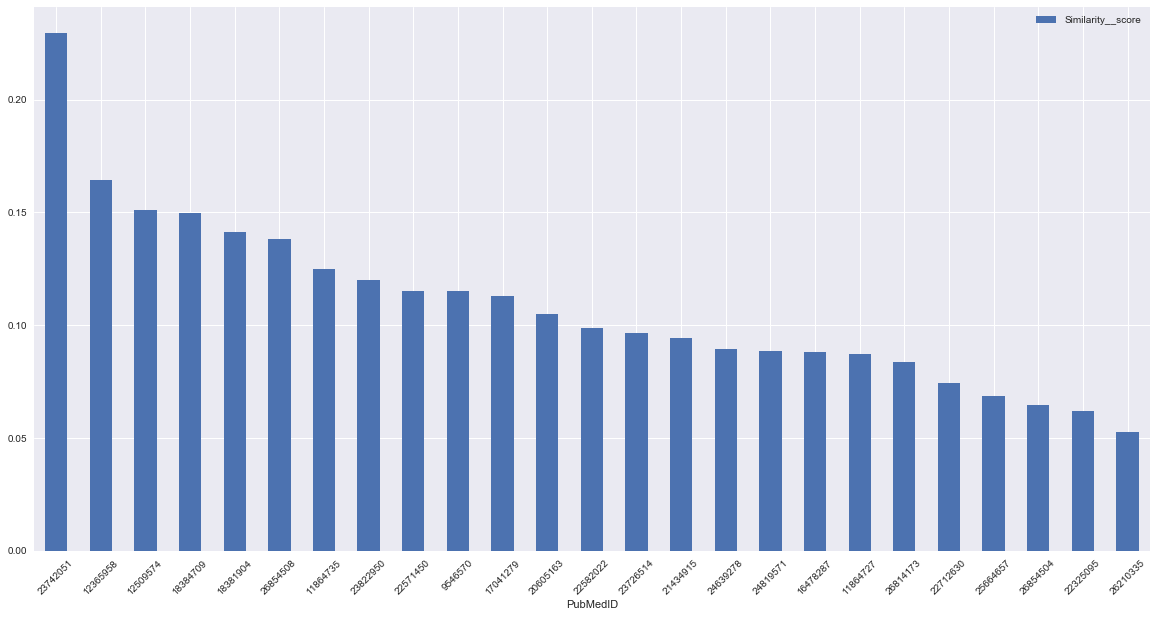

    PubMedID  Similarity__score
0   15860370           1.000000
15  23742051           0.229589
22  12365958           0.164531
2   12509574           0.151074
16  18384709           0.149868
25  18381904           0.141169
13  26854508           0.138263
21  11864735           0.125045
4   23822950           0.119991
10  22571450           0.115176
8    9546570           0.115174
18  17041279           0.112788
19  20605163           0.104777
12  22582022           0.098933
20  23726514           0.096548
5   21434915           0.094284
1   24639278           0.089235
23  24819571           0.088575
3   16478287           0.088289
7   11864727           0.087154
14  26814173           0.083813
9   22712630           0.074217
6   25664657           0.068448
24  26854504           0.064705
17  22325095           0.062111
11  26210335           0.052580


In [197]:
s="0 15860370 vs 15860370 100 \
1 15860370 vs 24639278 47 \
2 15860370 vs 12509574 45 \
3 15860370 vs 16478287 44 \
4 15860370 vs 23822950 43 \
5 15860370 vs 21434915 43 \
6 15860370 vs 25664657 43 \
7 15860370 vs 11864727 42 \
8 15860370 vs 9546570 42 \
9 15860370 vs 22712630 42 \
10 15860370 vs 22571450 41 \
11 15860370 vs 26210335 41 \
12 15860370 vs 22582022 41 \
13 15860370 vs 26854508 40 \
14 15860370 vs 26814173 40 \
15 15860370 vs 23742051 39 \
16 15860370 vs 18384709 39 \
17 15860370 vs 22325095 39 \
18 15860370 vs 17041279 39 \
19 15860370 vs 20605163 39 \
20 15860370 vs 23726514 39 \
21 15860370 vs 11864735 39 \
22 15860370 vs 12365958 39 \
23 15860370 vs 24819571 39 \
24 15860370 vs 26854504 39 \
25 15860370 vs 18381904 39"
pmid_list = PreparePMID(s)
print("length of pmid= ", len(pmid_list))

#Preprocessing - Calculating TFs, IDF, Alpha
reset_var(n_bins=20, ig_zero=True, show_d=False)
for pm in pmid_list:
    df = getListofWords(pm)
    paper_word_list.append(df)
    paper_tf_list.append(dict(Counter(df.Word)))
    temp_dict = {}
    for _, d in df.iterrows():
        temp_dict[d["Word"]] = d["alpha"]
    paper_alpha_word_list.append(temp_dict)


N = len(pmid_list)
for w in paper_tf_list[0]:
    count = 0
    for paper in paper_tf_list:
        if(w in paper):
            count=count+1
    paper_idf_dict[w] = np.log((N / (count)) + 0.01)
    

#Algorithm 

style_score_list = []
coef = 0.1 

ref_words = paper_tf_list[0]
for ind, paper in enumerate(paper_tf_list):
    style_score = 0
    for word in ref_words:
        if word not in paper:
            if paper_alpha_word_list[0][word] > Threshold:
                TFscore = ComputeTF(tf=ref_words[word], a=paper_alpha_word_list[0][word])
                IDF_score = paper_idf_dict[word]
                al = paper_alpha_list[0]
                style_score = style_score + coef*ComputeScore(TF=TFscore, IDF=IDF_score, a_paper=al)
        else:
            TFscore = ComputeTF(tf=paper[word], a=paper_alpha_word_list[ind][word])
            IDF_score = paper_idf_dict[word]
            al = paper_alpha_list[ind]
            style_score = style_score + ComputeScore(TF=TFscore, IDF=IDF_score, a_paper=al)
    style_score_list.append(style_score)
print(style_score_list)
style_score_list = np.array(style_score_list)
style_score_list = style_score_list/style_score_list[0]


#Plot similarity score
xx = [str(x) for x in pmid_list]
comparison_df = pd.DataFrame({"PubMedID": xx, "Similarity__score": style_score_list})
comparison_df.sort_values(['Similarity__score'], ascending=[0])[1:].plot.bar(x="PubMedID")
#comparison_df.plot.bar(x="PubMedID")
plt.xticks(rotation=45)
plt.show()
comparison_df = comparison_df.sort_values(['Similarity__score'], ascending=[0])
print(comparison_df)

length of pmid=  21
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=11864727
Left Normal Curve score or alpha for this paper =  0.400901658273
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=10670429
Left Normal Curve score or alpha for this paper =  0.67014226418
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=10399773
Left Normal Curve score or alpha for this paper =  0.700546465052
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=10580313
Left Normal Curve score or alpha for this paper =  0.445832338863
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=11274716
Left Normal Curve score or alpha for this paper =  0.629855073846
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=9804875
Left Normal Curve score or alpha for this paper =  0.453697660538
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=16136298
Left Normal Curve score or alpha for this paper =  0.691811551996
http://abel.lis.illinois.edu/cgi-bin/

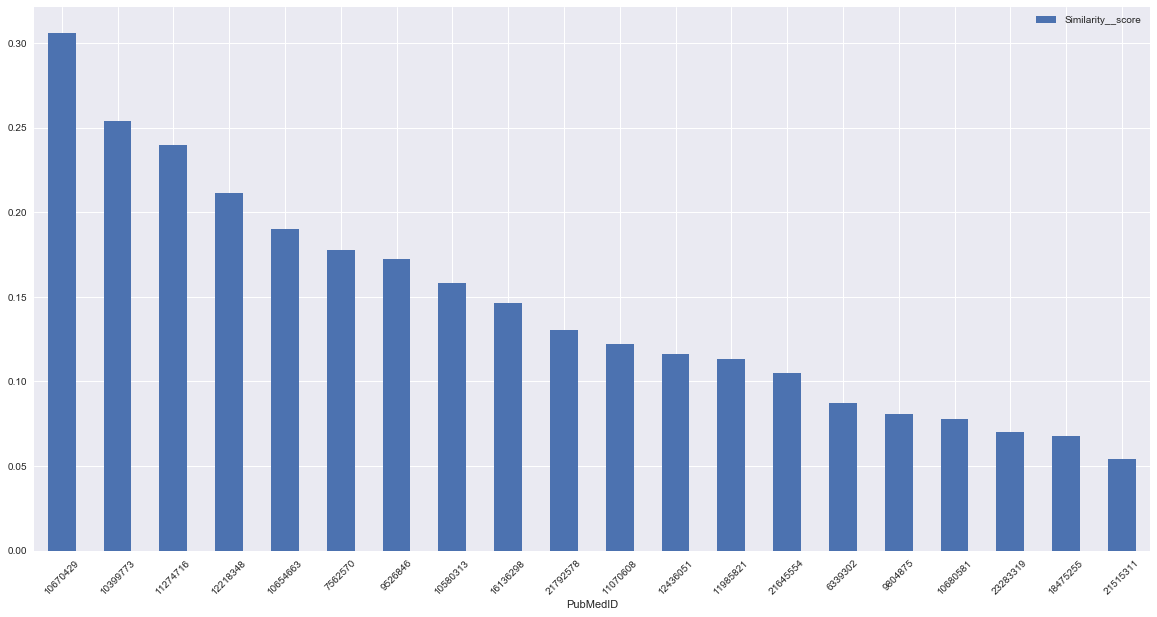

    PubMedID  Similarity__score
0   11864727           1.000000
1   10670429           0.306018
2   10399773           0.253747
4   11274716           0.239729
14  12218348           0.211551
11  10654663           0.189873
18   7562570           0.177977
19   9526846           0.172518
3   10580313           0.158092
6   16136298           0.146539
7   21792578           0.130398
17  11070608           0.122037
13  12436051           0.116146
10  11985821           0.113129
9   21645554           0.104890
16   6339302           0.087245
5    9804875           0.080673
12  10680581           0.077789
20  23283319           0.070388
15  18475255           0.067576
8   21515311           0.054061


In [203]:
s="0 11864727 vs 11864727 156 \
1 11864727 vs 10670429 64 \
2 11864727 vs 10399773 59 \
3 11864727 vs 10580313 58 \
4 11864727 vs 11274716 51 \
5 11864727 vs 9804875 44 \
6 11864727 vs 16136298 43 \
7 11864727 vs 21792578 43 \
8 11864727 vs 21515311 41 \
9 11864727 vs 21645554 40 \
10 11864727 vs 11985821 37 \
11 11864727 vs 10654663 35 \
12 11864727 vs 10680581 34 \
13 11864727 vs 12436051 34 \
14 11864727 vs 12218348 34 \
15 11864727 vs 18475255 33 \
16 11864727 vs 6339302 33 \
17 11864727 vs 11070608 33 \
18 11864727 vs 7562570 33 \
19 11864727 vs 9526846 33 \
20 11864727 vs 23283319 33 "
pmid_list = PreparePMID(s)
print("length of pmid= ", len(pmid_list))

#Preprocessing - Calculating TFs, IDF, Alpha
reset_var(n_bins=20, ig_zero=True, show_d=False)
for pm in pmid_list:
    df = getListofWords(pm)
    paper_word_list.append(df)
    paper_tf_list.append(dict(Counter(df.Word)))
    temp_dict = {}
    for _, d in df.iterrows():
        temp_dict[d["Word"]] = d["alpha"]
    paper_alpha_word_list.append(temp_dict)


N = len(pmid_list)
for w in paper_tf_list[0]:
    count = 0
    for paper in paper_tf_list:
        if(w in paper):
            count=count+1
    paper_idf_dict[w] = np.log((N / (count)) + 0.01)
    

#Algorithm 

style_score_list = []
coef = 0.1 

ref_words = paper_tf_list[0]
for ind, paper in enumerate(paper_tf_list):
    style_score = 0
    for word in ref_words:
        if word not in paper:
            if paper_alpha_word_list[0][word] > Threshold:
                TFscore = ComputeTF(tf=ref_words[word], a=paper_alpha_word_list[0][word])
                IDF_score = paper_idf_dict[word]
                al = paper_alpha_list[0]
                style_score = style_score + coef*ComputeScore(TF=TFscore, IDF=IDF_score, a_paper=al)
        else:
            TFscore = ComputeTF(tf=paper[word], a=paper_alpha_word_list[ind][word])
            IDF_score = paper_idf_dict[word]
            al = paper_alpha_list[ind]
            style_score = style_score + ComputeScore(TF=TFscore, IDF=IDF_score, a_paper=al)
    style_score_list.append(style_score)
print(style_score_list)
style_score_list = np.array(style_score_list)
style_score_list = style_score_list/style_score_list[0]


#Plot similarity score
xx = [str(x) for x in pmid_list]
comparison_df = pd.DataFrame({"PubMedID": xx, "Similarity__score": style_score_list})
comparison_df.sort_values(['Similarity__score'], ascending=[0])[1:].plot.bar(x="PubMedID")
#comparison_df.plot.bar(x="PubMedID")
plt.xticks(rotation=45)
plt.show()
comparison_df = comparison_df.sort_values(['Similarity__score'], ascending=[0])
print(comparison_df)

length of pmid=  24
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=9526846
Left Normal Curve score or alpha for this paper =  0.622675275675
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=11045866
Left Normal Curve score or alpha for this paper =  0.698298263359
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=12218348
Left Normal Curve score or alpha for this paper =  0.724466513675
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=12689607
Left Normal Curve score or alpha for this paper =  0.721263977847
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=20850442
Left Normal Curve score or alpha for this paper =  0.869210422471
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=11238624
Left Normal Curve score or alpha for this paper =  0.51366203994
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=16423855
Left Normal Curve score or alpha for this paper =  0.863891096459
http://abel.lis.illinois.edu/cgi-bin/

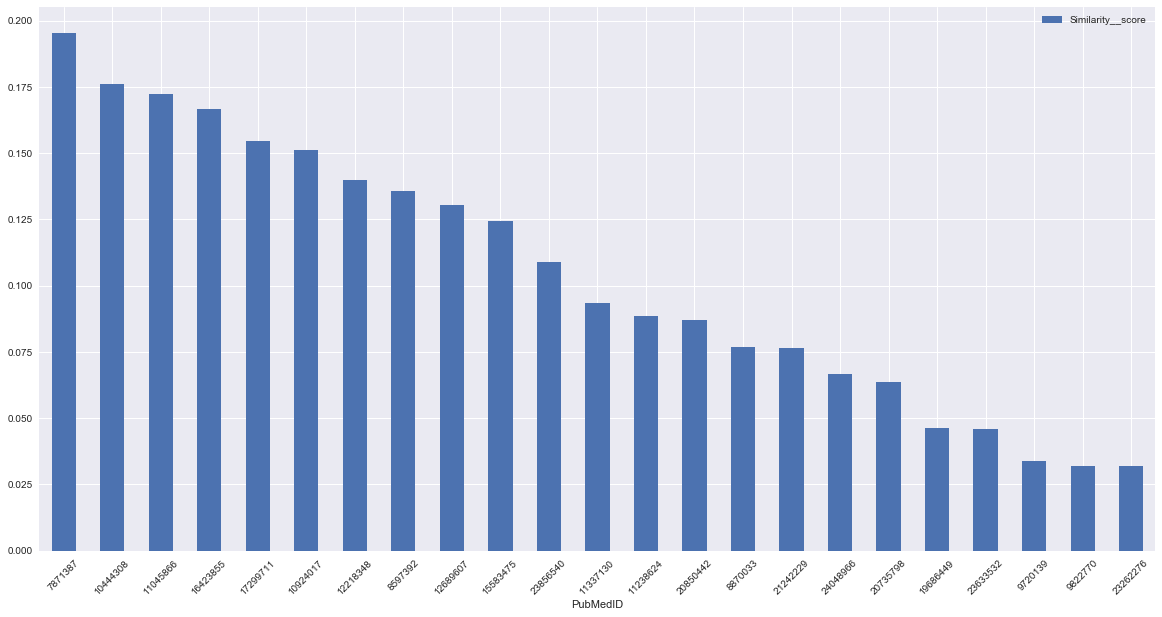

    PubMedID  Similarity__score
0    9526846           1.000000
9    7871387           0.195366
7   10444308           0.175993
1   11045866           0.172228
6   16423855           0.166579
8   17299711           0.154411
15  10924017           0.151080
2   12218348           0.139982
21   8597392           0.135612
3   12689607           0.130447
16  15583475           0.124200
12  23856540           0.108943
18  11337130           0.093469
5   11238624           0.088513
4   20850442           0.087196
11   8870033           0.076919
20  21242229           0.076439
14  24048966           0.066720
23  20735798           0.063776
17  19686449           0.046209
19  23633532           0.045874
10   9720139           0.033758
22   9822770           0.032016
13  23262276           0.031799


In [206]:
s="0 9526846 vs 9526846 149 \
1 9526846 vs 11045866 53 \
2 9526846 vs 12218348 51 \
3 9526846 vs 12689607 44 \
4 9526846 vs 20850442 44 \
5 9526846 vs 11238624 44 \
6 9526846 vs 16423855 41 \
7 9526846 vs 10444308 41 \
8 9526846 vs 17299711 41 \
9 9526846 vs 7871387 40 \
10 9526846 vs 9720139 40 \
11 9526846 vs 8870033 40 \
12 9526846 vs 23856540 39 \
13 9526846 vs 23262276 39 \
14 9526846 vs 24048966 39 \
15 9526846 vs 10924017 38 \
16 9526846 vs 15583475 38 \
17 9526846 vs 19686449 38 \
18 9526846 vs 11337130 38 \
19 9526846 vs 23633532 37 \
20 9526846 vs 21242229 37 \
21 9526846 vs 8597392 37 \
22 9526846 vs 9822770 37 \
23 9526846 vs 20735798 37 "
pmid_list = PreparePMID(s)
print("length of pmid= ", len(pmid_list))

#Preprocessing - Calculating TFs, IDF, Alpha
reset_var(n_bins=20, ig_zero=True, show_d=False)
for pm in pmid_list:
    df = getListofWords(pm)
    paper_word_list.append(df)
    paper_tf_list.append(dict(Counter(df.Word)))
    temp_dict = {}
    for _, d in df.iterrows():
        temp_dict[d["Word"]] = d["alpha"]
    paper_alpha_word_list.append(temp_dict)


N = len(pmid_list)
for w in paper_tf_list[0]:
    count = 0
    for paper in paper_tf_list:
        if(w in paper):
            count=count+1
    paper_idf_dict[w] = np.log((N / (count)) + 0.01)
    

#Algorithm 

style_score_list = []
coef = 0.1 

ref_words = paper_tf_list[0]
for ind, paper in enumerate(paper_tf_list):
    style_score = 0
    for word in ref_words:
        if word not in paper:
            if paper_alpha_word_list[0][word] > Threshold:
                TFscore = ComputeTF(tf=ref_words[word], a=paper_alpha_word_list[0][word])
                IDF_score = paper_idf_dict[word]
                al = paper_alpha_list[ind]
                style_score = style_score + coef*ComputeScore(TF=TFscore, IDF=IDF_score, a_paper=al)
        else:
            TFscore = ComputeTF(tf=paper[word], a=paper_alpha_word_list[ind][word])
            IDF_score = paper_idf_dict[word]
            al = paper_alpha_list[ind]
            style_score = style_score + ComputeScore(TF=TFscore, IDF=IDF_score, a_paper=al)
    style_score_list.append(style_score)
print(style_score_list)
style_score_list = np.array(style_score_list)
style_score_list = style_score_list/style_score_list[0]


#Plot similarity score
xx = [str(x) for x in pmid_list]
comparison_df = pd.DataFrame({"PubMedID": xx, "Similarity__score": style_score_list})
comparison_df.sort_values(['Similarity__score'], ascending=[0])[1:].plot.bar(x="PubMedID")
#comparison_df.plot.bar(x="PubMedID")
plt.xticks(rotation=45)
plt.show()
comparison_df = comparison_df.sort_values(['Similarity__score'], ascending=[0])
print(comparison_df)

length of pmid=  21
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=11238624
Left Normal Curve score or alpha for this paper =  0.51366203994
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=8945973
Left Normal Curve score or alpha for this paper =  0.334858339545
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=11212944
Left Normal Curve score or alpha for this paper =  0.350260691053
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=25929804
Left Normal Curve score or alpha for this paper =  0.65589310859
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=6707474
Left Normal Curve score or alpha for this paper =  0.2750052581
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=16280381
Left Normal Curve score or alpha for this paper =  0.285631258138
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=8206100
Left Normal Curve score or alpha for this paper =  0.342180635564
http://abel.lis.illinois.edu/cgi-bin/cohes

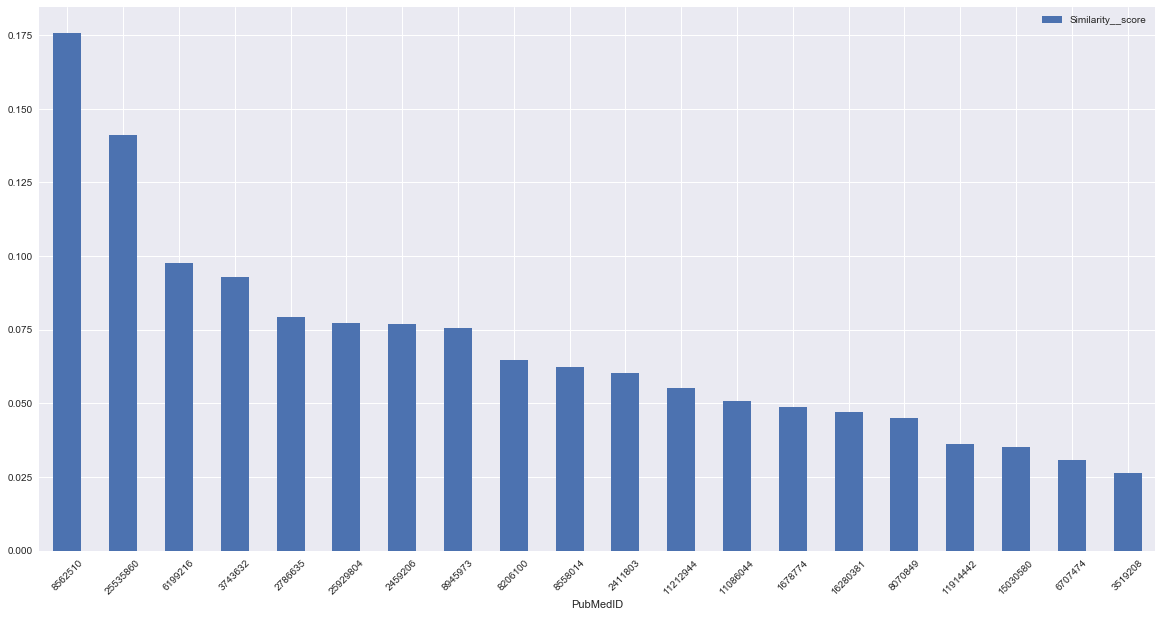

    PubMedID  Similarity__score
0   11238624           1.000000
20   8562510           0.175784
8   25535860           0.141066
16   6199216           0.097492
18   3743632           0.092797
9    2786635           0.079374
3   25929804           0.077410
15   2459206           0.076831
1    8945973           0.075656
6    8206100           0.064641
11   8558014           0.062190
10   2411803           0.060292
2   11212944           0.055188
12  11086044           0.050893
17   1678774           0.048612
5   16280381           0.047008
19   8070849           0.044929
13  11914442           0.036334
14  15030580           0.035219
4    6707474           0.030805
7    3519208           0.026275


In [207]:
s="0 11238624 vs 11238624 147 \
1 11238624 vs 8945973 90 \
2 11238624 vs 11212944 71 \
3 11238624 vs 25929804 65 \
4 11238624 vs 6707474 64 \
5 11238624 vs 16280381 62 \
6 11238624 vs 8206100 60 \
7 11238624 vs 3519208 59 \
8 11238624 vs 25535860 58 \
9 11238624 vs 2786635 57 \
10 11238624 vs 2411803 57 \
11 11238624 vs 8558014 56 \
12 11238624 vs 11086044 56 \
13 11238624 vs 11914442 56 \
14 11238624 vs 15030580 56 \
15 11238624 vs 2459206 55 \
16 11238624 vs 6199216 55 \
17 11238624 vs 1678774 55 \
18 11238624 vs 3743632 55 \
19 11238624 vs 8070849 55 \
20 11238624 vs 8562510 55 "
pmid_list = PreparePMID(s)
print("length of pmid= ", len(pmid_list))

#Preprocessing - Calculating TFs, IDF, Alpha
reset_var(n_bins=20, ig_zero=True, show_d=False)
for pm in pmid_list:
    df = getListofWords(pm)
    paper_word_list.append(df)
    paper_tf_list.append(dict(Counter(df.Word)))
    temp_dict = {}
    for _, d in df.iterrows():
        temp_dict[d["Word"]] = d["alpha"]
    paper_alpha_word_list.append(temp_dict)


N = len(pmid_list)
for w in paper_tf_list[0]:
    count = 0
    for paper in paper_tf_list:
        if(w in paper):
            count=count+1
    paper_idf_dict[w] = np.log((N / (count)) + 0.01)
    

#Algorithm 

style_score_list = []
coef = 0.1 

ref_words = paper_tf_list[0]
for ind, paper in enumerate(paper_tf_list):
    style_score = 0
    for word in ref_words:
        if word not in paper:
            if paper_alpha_word_list[0][word] > Threshold:
                TFscore = ComputeTF(tf=ref_words[word], a=paper_alpha_word_list[0][word])
                IDF_score = paper_idf_dict[word]
                al = paper_alpha_list[ind]
                style_score = style_score + coef*ComputeScore(TF=TFscore, IDF=IDF_score, a_paper=al)
        else:
            TFscore = ComputeTF(tf=paper[word], a=paper_alpha_word_list[ind][word])
            IDF_score = paper_idf_dict[word]
            al = paper_alpha_list[ind]
            style_score = style_score + ComputeScore(TF=TFscore, IDF=IDF_score, a_paper=al)
    style_score_list.append(style_score)
print(style_score_list)
style_score_list = np.array(style_score_list)
style_score_list = style_score_list/style_score_list[0]


#Plot similarity score
xx = [str(x) for x in pmid_list]
comparison_df = pd.DataFrame({"PubMedID": xx, "Similarity__score": style_score_list})
comparison_df.sort_values(['Similarity__score'], ascending=[0])[1:].plot.bar(x="PubMedID")
#comparison_df.plot.bar(x="PubMedID")
plt.xticks(rotation=45)
plt.show()
comparison_df = comparison_df.sort_values(['Similarity__score'], ascending=[0])
print(comparison_df)